> Code to accompany **Chapter 6: Methods for Generating Adversarial Perturbation**

# ResNet50 Foolbox Saliency Attack

The saliency attack focusses on permutating pixels in the image that are most salient to the adversarial misclassification or adversarial target classification.

The Jacobian Saliency Map Approach (JSMA) is described in greater detail in chapter 6. The paper describing this approach is [Nicolas Papernot et al., “The Limitations of Deep Learning in Adversarial Settings,” 1st IEEE European Symposium on Security & Privacy (2016)](https://arxiv.org/abs/1511.07528).


To begin, import some libararies and dependencies.

In [1]:
# Import the model
import tensorflow as tf
from tensorflow import keras
from keras.applications.resnet50 import ResNet50
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import helper function
import sys
sys.path.append('..')
from strengtheningdnns.image_utils import image_from_file

Using TensorFlow backend.


## Select our non adversarial image and see what ResNet50 classifies it as

In [2]:
original_image_path = '../images/koala.jpg'
x = image_from_file(original_image_path, [224,224])


(?, ?, ?)
Re-scaling image to  [224, 224]


We'll re-scale it and check that it is correctly classified.

Get the ResNet50 model

In [3]:
model = ResNet50(weights='imagenet', include_top=True)

Instructions for updating:
Colocations handled automatically by placer.


Prediction for image:  koala


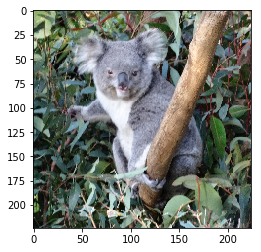

In [5]:
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import decode_predictions

x_preds = model.predict(np.expand_dims(preprocess_input(x), 0))
y = np.argmax(x_preds)
y_name = decode_predictions(x_preds, top=1)[0][0][1]
print("Prediction for image: ", y_name)

plt.imshow(x)

## Create the equivalent foolbox model from the Keras one


The Foolbox model is able to perform pre-processing on the image to make it suitable to ResNet50. This involves normalising the data around the ImageNet mean RGB values on which the classifier was initially trained. The ```preprocessing``` variable defines the means for this pre-processing step. The equivalent normalisation is done in ```keras.applications.resnet50.preprocess_input``` - the function that we have called previously to prepare input for ResNet50. 

If you are interested in understanding this pre-processing step in greater detail, take a look at
[the ResNet50Preprocessing.ipynb file on Github](https://github.com/katywarr/strengthening-dnns/blob/master/chapter04/resnet50_preprocessing.ipynb) or, if you are running the notebooks, [run the ResNet50Preprocessing.ipynb notebook](../chapter04/resnet50_preprocessing.ipynb).

In [6]:
preprocessing = (np.array([103.939, 116.779, 123.68]), 1)

ResNet50 was trained on images with the channels ordered BGR, rather than RGB. This step switches the channels of the image data to BGR. This is another step in ```keras.applications.resnet50.preprocess_input.```

In [7]:
x_bgr = x[..., ::-1]


Create the foolbox model passing the information required for pre-processing.

In [8]:
import foolbox

# Temporary using Keras Model to get around bug that looks like: 
# https://github.com/bethgelab/foolbox/issues/164 
fmodel = foolbox.models.KerasModel(model, bounds=(0, 255), 
                                   preprocessing=preprocessing)
#fmodel = foolbox.models.TensorFlowModel.from_keras(model, 
#                                                   bounds=(0, 255), 
#                                                   preprocessing=preprocessing)

Instructions for updating:
Use tf.cast instead.


## Define the attack specificity

[foolbox.criteria](https://foolbox.readthedocs.io/en/latest/modules/criteria.html) defines the attach specificity (targeted versus untargeted) and the probability threshold required. 
 

In [9]:
attack_criterion = foolbox.criteria.Misclassification()

## Define the attack method

In [10]:
attack = foolbox.attacks.SaliencyMapAttack(fmodel, criterion=attack_criterion)

## Run the attack

In [11]:
adversarial = attack(input_or_adv = x_bgr, label = y, unpack = False)

In [12]:
x_adv = adversarial.image[..., ::-1]

x_adv_preds = model.predict(preprocess_input(x_adv[np.newaxis].copy()))
y_adv = np.argmax(x_adv_preds)
y_adv_name = decode_predictions(x_adv_preds, top=1)[0][0][1]
print(print("Prediction for image: ", y_adv_name))

Prediction for image:  weasel
None


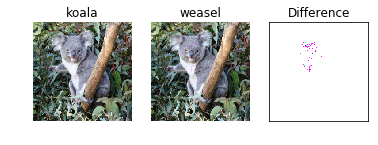

In [14]:

plt.figure()

# Plot the original image
plt.subplot(1, 3, 1)
plt.title(y_name)
plt.imshow(x)  
plt.axis('off')

# Plot the adversarial image
plt.subplot(1, 3, 2)
plt.title(y_adv_name)
plt.imshow(x_adv)  
plt.axis('off')

# Plot the difference
plt.subplot(1, 3, 3)
plt.title('Difference')
difference = x_adv - x
# Set differences that haven't changed to 255 so they don't show on the plot 
difference[difference == 0] = 255 
plt.imshow(abs(difference))
plt.xticks([])
plt.yticks([])

plt.show()


## Where next?

Take a look at a examples of attacks on the Fashion-MNIST dataset. For example:

* The Foolbox gradient attack (white box). Here's the [Jupyter notebook on GitHub](https://github.com/katywarr/strengthening-dnns/blob/master/chapter06/fashionMNIST_foolbox_gradient.ipynb) and here's the [relative path to the Jypyter notebook](./fashionMNIST_foolbox_gradient.ipynb) if you want to run it.

* The Foolbox boundary attack (black-box). Here's the [Jupyter notebook on GitHub](https://github.com/katywarr/strengthening-dnns/blob/master/chapter06/fashionMNIST_foolbox_boundary.ipynb) and here's the [relative path to the Jypyter notebook](./fashionMNIST_foolbox_boundary.ipynb) if you want to run it.

There are many more examples of adversarial attacks online. See [RESOURCES.md](https://github.com/katywarr/strengthening-dnns/blob/master/RESOURCES.md) for links to collaborative projects for creating and defending against attacks.